# AHD Ticket Prioritization

## Importing necessary libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

from sklearn.feature_selection import chi2, f_classif

from sklearn.cluster import KMeans

import nltk
from nltk.draw.dispersion import dispersion_plot
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics, model_selection, naive_bayes
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings('ignore')

### Failed to import wordcloud, imblearn library, stopwords from nltk - installation not available

### wordcloud - for visualizing word frequencies
### imblearn - working with imbalance in the data set

In [13]:
# nltk.download('stopwords')

In [14]:
# !pip install wordcloud
# from wordcloud import WordCloud, STOPWORDS

# import imblearn

## Importing the data set

In [75]:
df = pd.read_csv('Data set/all_tickets.csv')
#printing the first 5 rows
df.head()  

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


## Basic preprocessing

In [16]:
# viewing the columns in the dataframe
df.columns

Index(['title', 'body', 'ticket_type', 'category', 'sub_category1',
       'sub_category2', 'business_service', 'urgency', 'impact'],
      dtype='object')

In [17]:
# viewing the columns and respective data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


In [18]:
# count of null values in each column
df.isnull().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

In [19]:
# five number summary of each categorical column
df.describe()

,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
count,48549.000000,48549.000000,48549.000000,48549.000000,48549.000000,48549.000000,48549.000000
mean,0.713115,4.491153,11.614390,32.004634,49.482605,2.506066,3.677460
std,0.452312,1.103556,13.752707,33.602122,22.806100,0.855646,0.591513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,2.000000,7.000000,32.000000,2.000000,3.000000
50%,1.000000,4.000000,3.000000,21.000000,49.000000,3.000000,4.000000
75%,1.000000,5.000000,21.000000,53.000000,67.000000,3.000000,4.000000
max,1.000000,12.000000,58.000000,114.000000,102.000000,3.000000,4.000000


## EDA of numerical (categorical) columns

In [76]:
# extracting categorical features from data frame
temp_df = df.iloc[:, 2:].copy()
temp_df.head()

,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,1,4,2,21,71,3,4
1,1,6,22,7,26,3,4
2,1,5,13,7,32,3,4
3,1,5,13,7,32,3,4
4,1,4,2,76,4,3,4


## Count plot of each categorical column

In [77]:
# display the unique values from each categorical column
for column in temp_df.columns:
    print(column)
    display(temp_df[column].unique())
    print('-' *120)

ticket_type


array([1, 0], dtype=int64)

------------------------------------------------------------------------------------------------------------------------
category


array([ 4,  6,  5,  7, 11,  1,  8, 12,  3,  9,  0, 10,  2], dtype=int64)

------------------------------------------------------------------------------------------------------------------------
sub_category1


array([ 2, 22, 13,  3,  1, 15, 39, 36, 33, 17, 30, 50, 16, 56, 55, 11, 43,
        6, 58, 29, 26, 42, 37,  8, 24, 45, 25,  0, 52, 28, 31, 46, 38, 20,
        4, 48, 18,  5, 44, 21, 51,  9, 12, 35, 32, 10, 14, 41, 54, 27, 53,
       49, 40, 57, 23, 19, 34,  7, 47], dtype=int64)

------------------------------------------------------------------------------------------------------------------------
sub_category2


array([ 21,   7,  76,  87,  60,  94,  88,  86, 105,  51,   0,   3,  91,
       107, 108,  61,  95,  73,  12,   6,  16,   9,  70, 102,  33,  26,
       104,  68,  44,  93,  27, 100,  46,  92,  75,   8,  10,  19,  85,
        36,  39,  31, 114,  79,   1,  41,  11,  23,  74,  65, 106, 111,
        77,  29,  40,  53,  89,  63,  71,  98,  82,  62,  78,  50, 110,
        22, 112, 101,   4,  55,  30,  90,  83,  54,  66,  17,  57,  32,
        59,  20,   2,  14,  80,  97,  13,  24,  43, 109,  84,  35,  69,
        42,  96, 113,  37,  28,  48,  67,  81,   5,  34,  18,  58,  99,
        25,  45,  72,  49,  38,  52,  64, 103,  15,  47,  56], dtype=int64)

------------------------------------------------------------------------------------------------------------------------
business_service


array([ 71,  26,  32,   4,  89,  95,  66,  67,  74,  40,  36,  10,  52,
        73,  70,  38,  43,  46,  19,  92,  51,  49,  63,   2,  87,  96,
        48,  29,  27,  41,  65,   7,  68, 100,  24,  88,  56,   6,  58,
        21,   3,  59,  72,  62,  25,  45,  57,  99,  53,   5,  20,  23,
        64,  93,  42,  98,   9,  34,  30,  78,  94,  91,  16,  83,  11,
        28,  69,  90,  15,  14,  97,   8, 101,  33,  79,  76,  12,  39,
        50,  84,  85,  13,  81,  60,  61,  22,  18,   1,  54,  44,  82,
        86,  77,  35, 102,  55,  75,  47,  37,  80,  31,  17,   0],
      dtype=int64)

------------------------------------------------------------------------------------------------------------------------
urgency


array([3, 0, 1, 2], dtype=int64)

------------------------------------------------------------------------------------------------------------------------
impact


array([4, 3, 2, 0, 1], dtype=int64)

------------------------------------------------------------------------------------------------------------------------


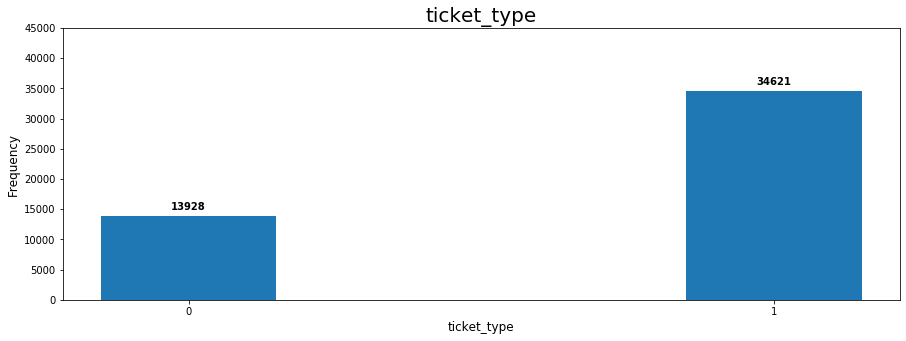

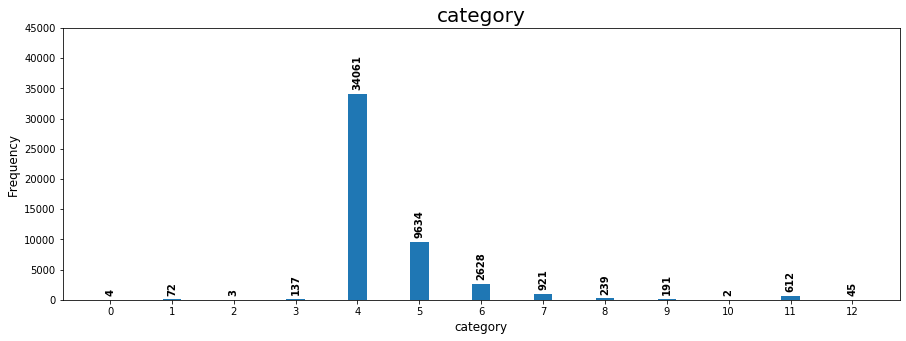

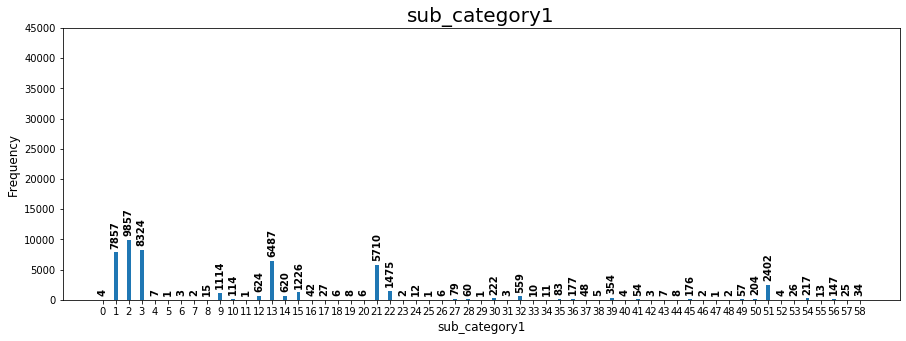

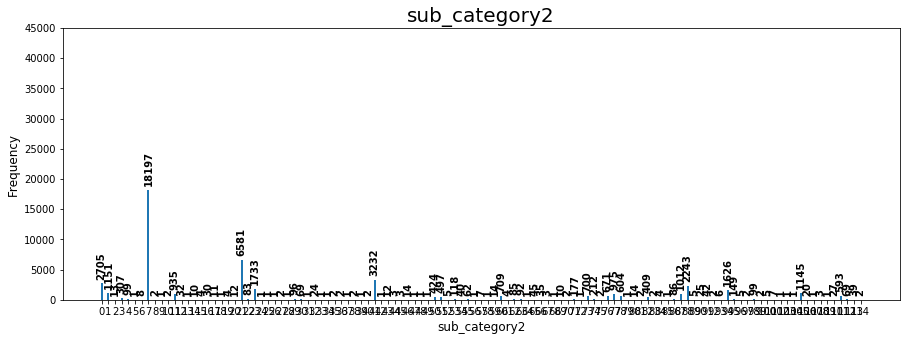

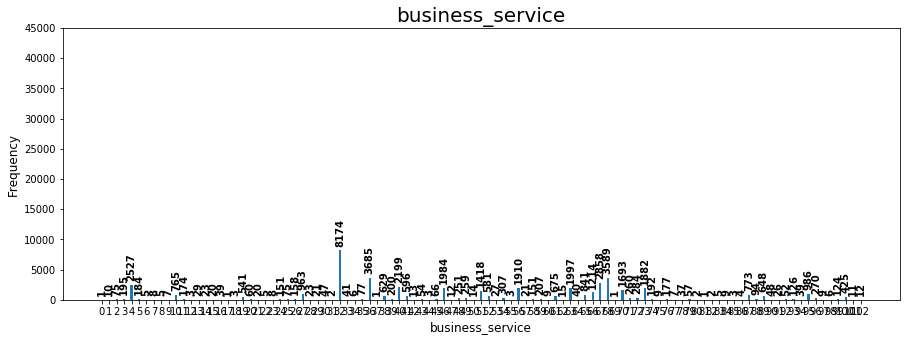

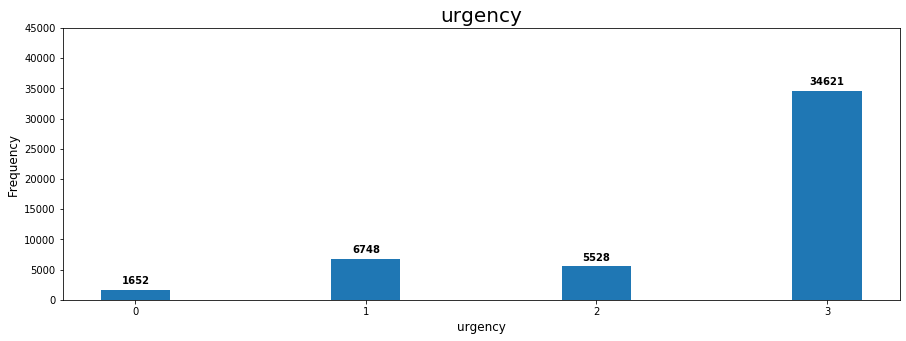

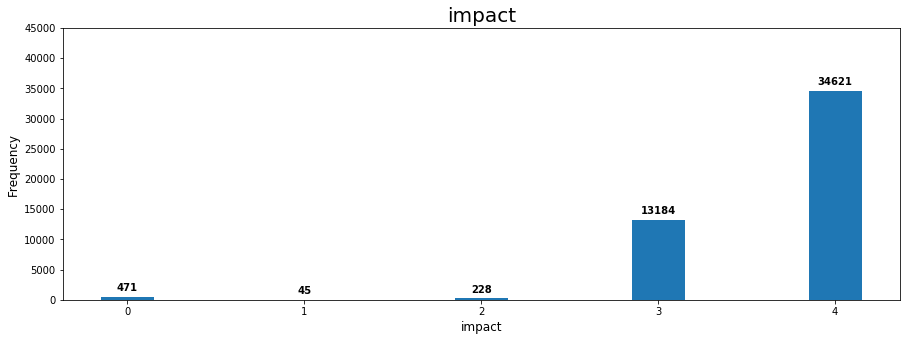

In [21]:
width=0.3
for column in temp_df.columns:
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_ylim([0, 45000])
    plt.title(column, fontsize=20)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # calculating count of rows in each category
    count_value = temp_df[column].value_counts(sort=True)
    plt.xticks(count_value.index, count_value.index)
    plt.bar(count_value.index, count_value.values, width)
    
    # printing text over the bar graphs for each category
    for index in count_value.index:
        if(column in ['category', 'sub_category1', 'sub_category2', 'business_service']):
            ax.text(index , count_value[index]+1000, str(count_value[index]), fontweight='bold',
               ha='center', rotation=90)
        else:
            ax.text(index , count_value[index]+1000, str(count_value[index]), fontweight='bold',
               ha='center')
    plt.show()

### From the urgency plot we can see the imbalance in row count belonging to each urgency level. Data is highly skewed towards urgency level 3. Here we consider only urgency column because it is our target column

## Pivot table vs group by

### Pivot table

In [22]:
pivot_table = pd.pivot_table(temp_df, values='impact', index=['urgency', 'ticket_type'],
                             columns=['category'], aggfunc='count', fill_value=0)
display(pivot_table)

,category,0,1,2,3,4,5,6,7,8,9,10,11,12
urgency,ticket_type,,,,,,,,,,,,,
0,0,0,1,1,0,1113,126,370,0,2,0,0,39,0
1,0,0,13,2,96,4673,1264,273,0,28,97,0,302,0
2,0,0,11,0,4,3752,1157,211,0,153,69,0,168,3
3,1,4,47,0,37,24523,7087,1774,921,56,25,2,103,42


### Pivot table gives us a better idea about the number of rows grouped into various columns

### Grouping categorical columns with urgency

In [74]:
for column in temp_df.columns:
    if(column != 'urgency'):
        temp_df_grouped = temp_df.groupby(by=[column, 'urgency']).count()
        temp_df_grouped['count'] = temp_df_grouped.iloc[:, 0]
        display(temp_df_grouped[['count']].style)

### Plotting the grouped columns

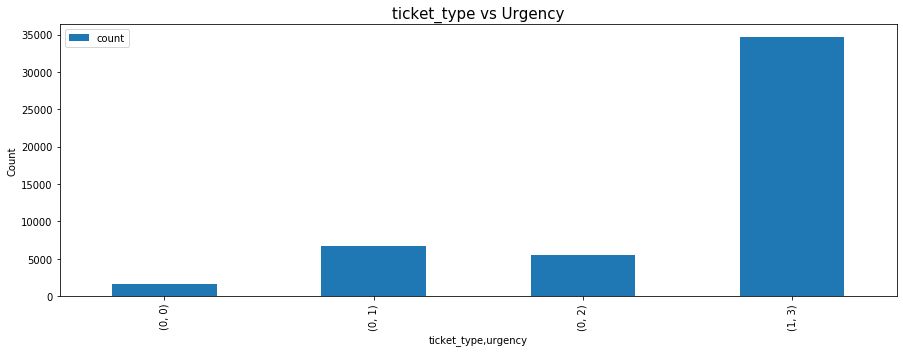

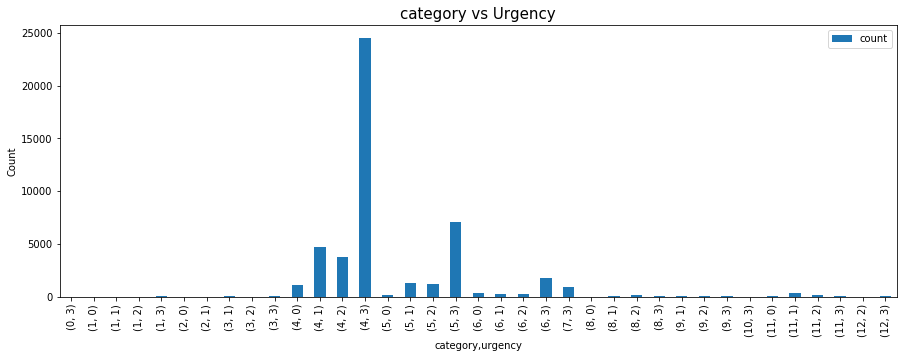

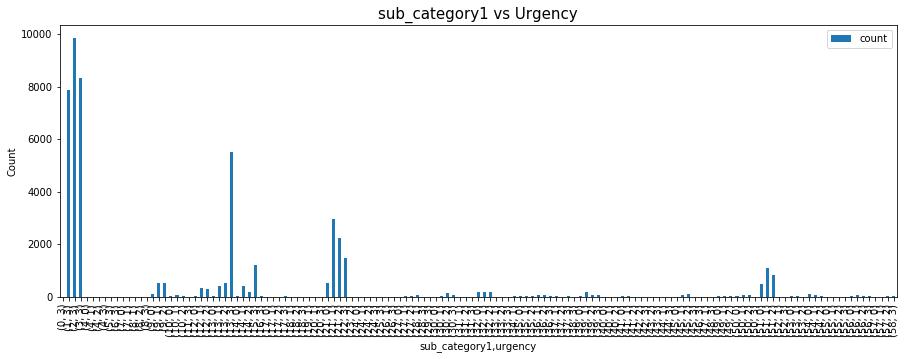

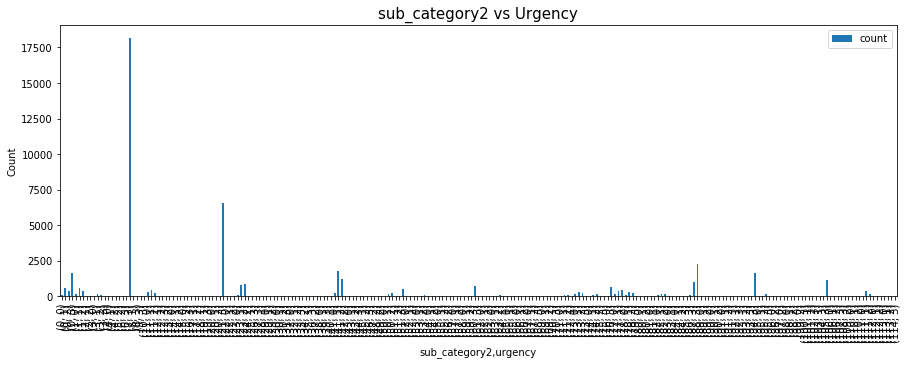

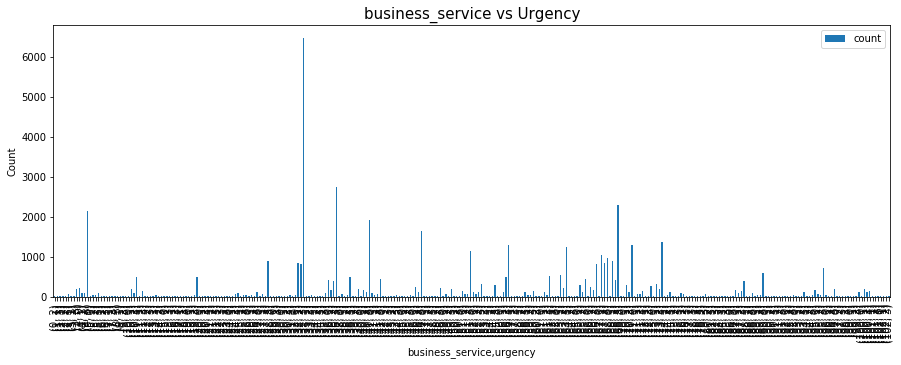

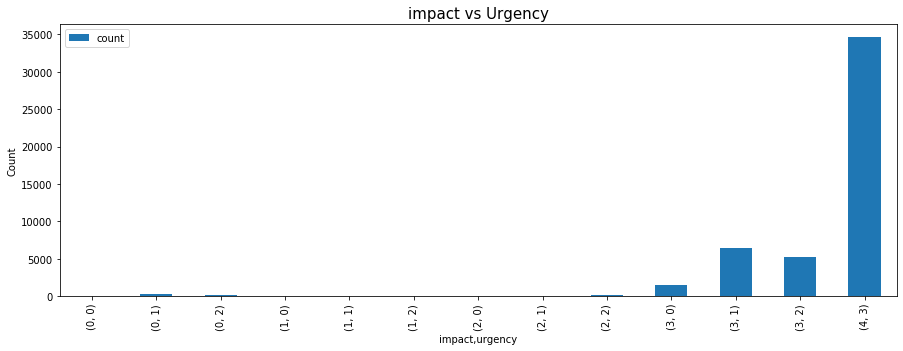

In [24]:
for column in temp_df.columns:   
    if(column != 'urgency'):
        temp_df_grouped = temp_df.groupby(by=[column, 'urgency']).count()
        
        # the first column from the data frame is renamed to 'count'
        temp_df_grouped['count'] = temp_df_grouped.iloc[:, 0]
        temp_df_grouped[['count']].plot.bar(figsize=(15, 5))
        plt.ylabel('Count')
        plt.title(column+" vs Urgency", fontsize=15)
        plt.show()

### Chi-squared test -- correlation/dependency between catagorical variables

In [25]:
temp_df.head()

,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,1,4,2,21,71,3,4
1,1,6,22,7,26,3,4
2,1,5,13,7,32,3,4
3,1,5,13,7,32,3,4
4,1,4,2,76,4,3,4


In [26]:
res = chi2(temp_df[['ticket_type', 'category', 'impact', 'sub_category1', 'sub_category2', 'business_service']], temp_df[['urgency']])

features = pd.DataFrame({'features': ['ticket_type', 'category', 'impact', 'sub_category1', 'sub_category2', 'business_service'], 'chi2': res[0], 'p-value': res[1]})
features

,features,chi2,p-value
0,ticket_type,13928.000000,0.000000e+00
1,category,127.837836,1.581229e-27
2,impact,3415.046592,0.000000e+00
3,sub_category1,408136.729884,0.000000e+00
4,sub_category2,72001.681734,0.000000e+00
5,business_service,12298.023404,0.000000e+00


### From the p-values we can conclude that none of the columns can be used to perform the intended classification beacuse the p-values are not greater than 0.05 which is the generally chosen significance value.
### This proves the independency of the categorical columns with the target column

## ANOVA Test

In [27]:
res = f_classif(temp_df[['ticket_type', 'category', 'impact', 'sub_category1', 'sub_category2', 'business_service']], temp_df[['urgency']])

features = pd.DataFrame({'features': ['ticket_type', 'category', 'impact', 'sub_category1', 'sub_category2', 'business_service'], 'chi2': res[0], 'p-value': res[1]})
features

,features,chi2,p-value
0,ticket_type,inf,0.000000e+00
1,category,1.586787e+02,2.361251e-102
2,impact,4.589811e+04,0.000000e+00
3,sub_category1,1.726834e+04,0.000000e+00
4,sub_category2,7.101108e+02,0.000000e+00
5,business_service,3.996063e+02,1.898928e-256


### Same interpretation can be made from the ANOVA test as well

## EDA of text columns

In [28]:
# displaying the text columns
df[['title','body']].head()

,title,body
0,NaN,hi since recruiter lead permission approve req...
1,connection with icon,icon dear please setup icon per icon engineers...
2,work experience user,work experience user hi work experience studen...
3,requesting for meeting,requesting meeting hi please help follow equip...
4,reset passwords for external accounts,re expire days hi ask help update passwords co...


# Dispersion plot

# Visualisation of the Need of lemmatization/Stemming


In [30]:
# importing tree bank tokenizer
tk=TreebankWordTokenizer()
l1=tk.tokenize(df['body'].str.cat())

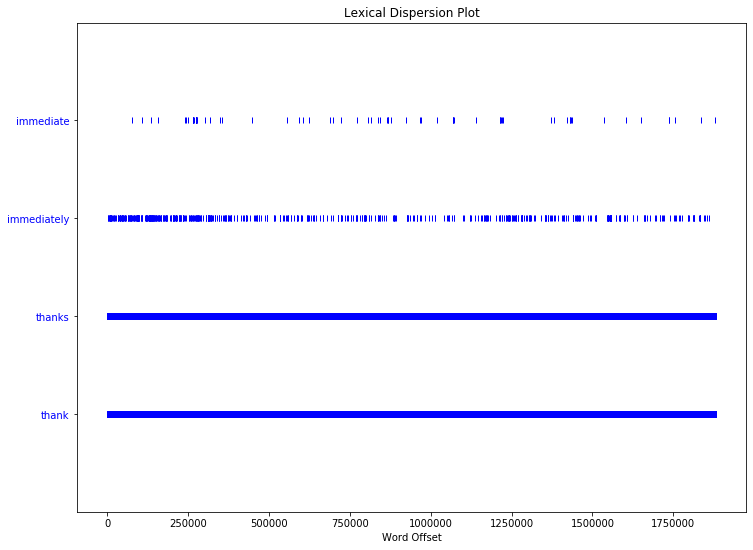

In [31]:
#dispersion_plot gives offset of given word in whole data
plt.figure(figsize=(12,9))
targets=["immediate","immediately",'thanks','thank']
dispersion_plot(l1,targets,ignore_case=True,title='Lexical Dispersion Plot')

### From the plot a consistent use of different words that have the same meaning is seen. Therefore, we can stem the appropriate words.

## Analysing frequency of Whole corpus

In [32]:
# finding frequency of each token
types=nltk.Counter(l1)
import operator

#frequency dictionary
typesdict=dict(sorted(types.items(),key=operator.itemgetter(1),reverse=True))
typesdict

{'please': 69214,
 'hi': 27785,
 'pm': 27344,
 'regards': 24153,
 'thank': 22395,
 'hello': 22002,
 'you': 21170,
 're': 18833,
 'for': 17243,
 'thanks': 16369,
 'kind': 13326,
 'can': 12824,
 'help': 10929,
 'dear': 10086,
 'with': 9443,
 'have': 9333,
 'by': 9314,
 'best': 9312,
 'july': 7653,
 'has': 7361,
 'error': 7342,
 'sent': 7239,
 'log': 6977,
 'be': 6920,
 'issue': 6875,
 'let': 6667,
 'attached': 6444,
 'tuesday': 6387,
 'date': 6344,
 'information': 6291,
 'we': 6247,
 'also': 6188,
 'change': 6164,
 'wednesday': 6109,
 'senior': 6001,
 'form': 5980,
 'add': 5885,
 'october': 5880,
 'details': 5876,
 'friday': 5855,
 'name': 5748,
 'thursday': 5713,
 'november': 5618,
 'ext': 5422,
 'order': 5395,
 'your': 5317,
 'leaver': 5218,
 'engineer': 5173,
 'access': 5141,
 'update': 4840,
 'could': 4812,
 'number': 4800,
 'code': 4779,
 'if': 4672,
 'provide': 4639,
 'site': 4637,
 'december': 4575,
 'leave': 4562,
 'work': 4513,
 'high': 4437,
 'create': 4381,
 'analyst': 4361,
 

### Filtering rows based on urgency level

In [33]:
t3df=df[df['urgency']==3]
t2df=df[df['urgency']==2]
t1df=df[df['urgency']==1]
t0df=df[df['urgency']==0]

In [34]:
# tokenizing based on urgency level
l31=tk.tokenize(t3df['body'].str.cat())
l21=tk.tokenize(t2df['body'].str.cat())
l11=tk.tokenize(t1df['body'].str.cat())
l01=tk.tokenize(t0df['body'].str.cat())

# Word distribution wrt Urgency categories

In [35]:
# finding frequency of each token based on urgency level
types3=nltk.Counter(l31)
types2=nltk.Counter(l21)
types1=nltk.Counter(l11)
types0=nltk.Counter(l01)

# frequency dictionary
typesdict3=dict(sorted(types3.items(),key=operator.itemgetter(1),reverse=True))
typesdict2=dict(sorted(types2.items(),key=operator.itemgetter(1),reverse=True))
typesdict1=dict(sorted(types1.items(),key=operator.itemgetter(1),reverse=True))
typesdict0=dict(sorted(types0.items(),key=operator.itemgetter(1),reverse=True))

### Checking the frequency of some domain specific words over urgency levels

### The below cell shows that the word 'urgent' has been repeated 872 times when the urgency level is 3. All the below cells are to be interpretted in the same manner.

In [36]:
typesdict3['urgent']

872

In [37]:
typesdict2['urgent']

96

In [38]:
typesdict1['urgent']

319

In [39]:
typesdict0['urgent']

96

In [40]:
typesdict3['important']

456

In [41]:
typesdict2['important']

112

In [42]:
typesdict1['important']

122

In [43]:
typesdict0['important']

55

In [44]:
typesdict3['immediately']

400

In [45]:
typesdict2['immediately']

61

In [46]:
typesdict1['immediately']

76

In [47]:
typesdict0['immediately']

32

## Visualising Most frequent words in each urgency level

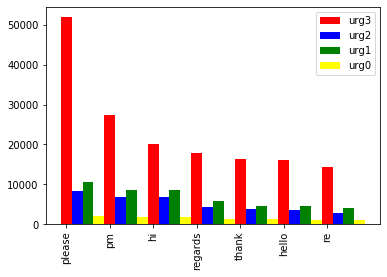

In [48]:
y_pos=np.arange(len(list(typesdict3.keys())[0:7]))

# plotting the dictionary values based on urgency level
plt.bar(y_pos,list(typesdict3.values())[0:7], color = 'red' ,width=0.25, label='urg3')
plt.bar(y_pos+0.25,list(typesdict2.values())[0:7], color = 'blue' ,width=0.25, label='urg2')
plt.bar(y_pos+0.5,list(typesdict1.values())[0:7], color = 'green' ,width=0.25, label='urg1')
plt.bar(y_pos+0.75,list(typesdict0.values())[0:7], color = 'yellow' ,width=0.25, label='urg0')
plt.xticks(rotation='vertical')
plt.legend()
plt.xticks(y_pos,list(typesdict3.keys())[0:7])
plt.show()

### The above graph shows the frequency of most repeated words in each urgency level. 

# Clustering

### Clustering with K-Means

In [49]:
# using TfidfVectorizer to generate, tokens from the body column of the given data
tfidf = TfidfVectorizer()
bow = tfidf.fit_transform(df['body'])
bow.shape

(48549, 12258)

### The Term frequency-inverse document frequency (TF-IDF) can be used in this data set to find how important a word is to this data set. It is used in a believe that, high frequency may not able to provide much information gain. In other words, rare words add more weights to the model. We have also applied CountVectorizer(). Both gives us the same vectors. But the TF-IDF model contains information on the more important words and the less important ones as well. It creates a matrix of features from the raw datasets.

In [50]:
# to understand what kind of words are generated as columns by tfidf
terms=tfidf.get_feature_names()
terms[1:10]

['abandon',
 'abandoned',
 'abbott',
 'abbreviations',
 'abc',
 'abeam',
 'abilities',
 'ability',
 'able']

In [51]:
# using KMeans clustering to cluster out the vectors
model = KMeans(n_clusters= 4,random_state=99)
model.fit(bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

### The KMeans algorithm allows us to identify the similar groups or clusters of data points very easily, when the data set is large. It groups the data into K clusters, based on some similarity in the data. 
### Here, we used the n_clusters attribute as 4, because from the given data set, we have identified that the target column 'urgency' have 4 classes. So, the output of KMeans should have 4 clusters and also it gives us the better result. The random_state determines the random number generation for centriod initilization.

In [52]:
# displaying the generated cluster centers
labels=model.labels_
cluster_centers=model.cluster_centers_
cluster_centers

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.62418340e-04, 0.00000000e+00, 6.62786619e-05, ...,
        1.25782241e-05, 1.50001563e-05, 0.00000000e+00],
       [5.02855751e-05, 1.41771500e-05, 6.89054115e-05, ...,
        7.20222224e-05, 0.00000000e+00, 1.72149444e-05]])

In [53]:
# To display distance between each cluster from K-Means
pair_wise_cluster_dist = euclidean_distances(cluster_centers)
pair_wise_cluster_dist = pd.DataFrame(pair_wise_cluster_dist, [0, 1, 2, 3], [0, 1, 2, 3])
pair_wise_cluster_dist

,0,1,2,3
0,0.000000,0.791804,0.767774,0.719682
1,0.791804,0.000000,0.405744,0.304726
2,0.767774,0.405744,0.000000,0.256030
3,0.719682,0.304726,0.256030,0.000000


### From the above code, we are able to identify the distance between the generated cluster centers. We have used Euclidean distance method, that the distance between any two objects is not affected by the addition of new objects to the analysis. The clusters generated  are not too far from each other.
### The intuition from inter_cluster distances is that clusters 2 and cluster 3 are closely related to each other.
### If heirarchical clustering was performed on the same data with the same number of clusters, the clusters 2 and 3 would be merged.

In [54]:
# to display top 10 words belonging to each cluster
print("Top terms per Cluster")
print()
order_centroids=model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(4):
    print("Cluster %d: " %i, end='')
    for ind in order_centroids[i, :10]:
        print('%s'%terms[ind], end='')
        print()
    print()

Top terms per Cluster

Cluster 0: item
purchased
po
purchase
consideration
receipts
ordered
mandatory
receive
section

Cluster 1: form
confluence
starter
leaver
please
pm
attached
hello
fill
thank

Cluster 2: you
for
sent
can
with
have
error
please
access
could

Cluster 3: please
pm
hi
thank
regards
thanks
hello
tuesday
add
july



### The above code can be used to display the frequent words of each cluster. It will give us an idea about the distribution of words in each cluster and also we can find the relationship between the words in a cluster.
### From this we can understand that, In the 'Cluster 0' the word's like "purchased, purchase, ordered, receipts" etc. are more frequent. So, the data in the cluster 0 will be related to some purchase of devices.
### In the 'Cluster 1' the word's like "form, starter, leaver" etc. are frequent. So, the data will be realated to Infrmation Technology related issues or mails.
### In the 'Cluster 2' the word's like "sent, error, access" etc. are repeating. This cluster might contain the datas related to access issues or error reports.
### In the 'Cluster 3' the word's like "pm, tuesday, july" are frequent. So, the cluster contains datas related to date and time. Also, the cluster have words like "hi, hello, thank, thanks, regards" etc. which are the starters and enders of a mail.

In [55]:
# using groupby to show how many points belong to each cluster
count_df = df.groupby(labels)['body'].count()
count_df

0     1176
1     3429
2    11708
3    32236
Name: body, dtype: int64

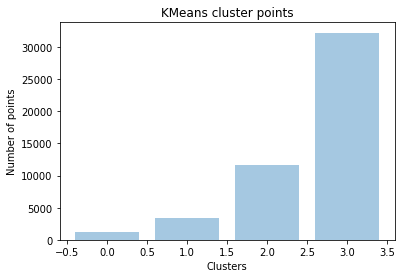

In [56]:
# visualize how many points are belonging to each cluster
plt.bar([x for x in range(4)], df.groupby(labels)['body'].count(),alpha=0.4)
plt.title('KMeans cluster points')
plt.xlabel("Clusters")
plt.ylabel("Number of points")
plt.show()

### From the above graph and count, we can understand the distribution of points into each cluster. The 'cluster 0' contains the highest number of data points(32236). The 'cluster 0' have the less number of data points(1176). The distribution of data points, rappidly increase from cluster 0 to cluster 3. 

In [57]:
# presenting a review of words belonging to each group
for i in range(4):
    print("A Review of assigned cluster", i)
    print("-" * 120)
    print(df.iloc[df.groupby(labels).groups[i][0]]['body'])
    print()
    print("-" * 120)

A Review of assigned cluster 0
------------------------------------------------------------------------------------------------------------------------
purchase po dear purchased received items lite updated include device under user name link please add allocation device thanks please log retrieve old device after receive item please take consideration mandatory receipts section order receive item ordered how video link please make return old device back accessories left receive receive old device take off user name kind regards administrator

------------------------------------------------------------------------------------------------------------------------
A Review of assigned cluster 1
------------------------------------------------------------------------------------------------------------------------
hello please fill date

------------------------------------------------------------------------------------------------------------------------
A Review of assigned cluster 2
-

### By reading  the review of each cluster, we can also find out the frequent words in each cluster.
### The cluster 0 contains the words related to some purchase of devices.
### The review of cluster 1 gives us only four words -"hello please fill date". So, from the review of cluster 1, we are not getting the expected information. Also, the clusters 2 and 3 are also not giving expected results from the review.


## Clustering with Latent Dirichlet Allocation (LDA)

### Now we are using LDA to perform clustering but the problem is we need  gensim library to perform som e good operations on that but this library is not available on vms so we used sklearn package to perform this but skearn doesn't have much methods through which we can visualise it properly.

In [58]:
lda = LatentDirichletAllocation(n_components=4,learning_method='online',random_state=99)
lda.fit(bow)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=99, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [59]:
topics=lda.transform(bow[:])
topics

array([[0.36451632, 0.06832293, 0.06844524, 0.49871551],
       [0.07526956, 0.17213906, 0.35684273, 0.39574864],
       [0.12073718, 0.29039268, 0.05884684, 0.5300233 ],
       ...,
       [0.30708726, 0.03428771, 0.62353479, 0.03509023],
       [0.2412357 , 0.1206381 , 0.60402365, 0.03410254],
       [0.20794486, 0.1660895 , 0.58373572, 0.04222991]])

### LDA is a distribution of distibution means this allocate different topics to the document and then randomly allocate words of the document to the topics.
### It checks how often a particular topic is occuring in a document and then it will check how often a particular word occuring in each topic

In [60]:
def print_top_words(lda,feature_names,n_top_words):
    for topic_id,topic in enumerate(lda.components_):
        print('\nTopic no. %d:' % int(topic_id+1))
        print(''.join([feature_names[i]+ ' '+str(round(topic[i],2)) + '|' for i in topic.argsort()[:-n_top_words -1:3]]))
        
n_top_words=4
print_top_words(lda,terms,n_top_words)


Topic no. 1:
transmittal 0.25|chartered 0.25|uncharted 0.25|crap 0.25|placer 0.25|goddard 0.25|conduce 0.25|reconfirm 0.25|cohen 0.25|biddy 0.25|stationery 0.25|guidebook 0.25|familia 0.25|substation 0.25|balancing 0.25|drains 0.25|revising 0.25|directional 0.25|fevers 0.25|manuals 0.25|sentinel 0.25|barker 0.25|areal 0.25|couching 0.25|berkeley 0.25|maiming 0.25|curses 0.25|booth 0.25|ferry 0.25|hush 0.25|fen 0.25|indoor 0.25|spooler 0.25|syndicates 0.25|dye 0.25|artefact 0.25|bib 0.25|shoes 0.25|screenplay 0.25|arias 0.25|lac 0.25|liberating 0.25|fighters 0.25|cordial 0.25|towers 0.25|serendipity 0.25|conus 0.25|discontinuity 0.25|wang 0.25|phrases 0.25|backlist 0.25|assessor 0.25|reloading 0.25|trued 0.25|muffin 0.25|superb 0.25|alfresco 0.25|fore 0.25|bps 0.25|secrecy 0.25|vain 0.25|avoided 0.25|overburden 0.25|xenon 0.25|pyramid 0.25|spirea 0.25|inutile 0.25|volt 0.25|distributive 0.25|franchise 0.25|beast 0.25|pones 0.25|syllabus 0.25|yugoslavia 0.25|erg 0.25|fathers 0.25|multip

In [61]:
# it gives us the distribution of words in each topic
lda.components_

array([[0.25202694, 0.52610275, 0.26439133, ..., 0.73851791, 0.25191708,
        0.28333669],
       [0.27608656, 0.31582807, 3.74349495, ..., 0.25798942, 0.29882624,
        0.25991067],
       [6.91124761, 0.25064796, 0.28570482, ..., 1.74143085, 0.43309533,
        0.25059645],
       [0.25328929, 0.25611363, 0.25082407, ..., 0.26856185, 0.25440128,
        0.6603976 ]])

In [62]:
# printing shape of the resulting components
lda.components_.shape

(4, 12258)

### The whole corpus was segregated into 4 topics as we can see. Whether these 4 topics represent the original segregation from the urgency column requires more experimentation. Each word is assigned a weightage with respect to each topic.

### Clustering techniques were used with the intention to downsample the majority class. Samples closely associated in the majority class can be identified and removed resulting in proper downsampling. The issue we encountered was that we were not able to track the particular row to which the data point in the cluster belonged to.

### Following part of the notebooks includes model building and evaluation

In [63]:
# create a column called kfold and fill it with -1
df['kfold'] = -1

# randomize the rows of the data
df = df.sample(frac=1).reset_index(drop=True)

# get target values
y = df['urgency'].values

# initiate the stratified kfold class from model_selection module
strat_kf = model_selection.StratifiedKFold(n_splits=5)

# fill the new kfold column
for f, (t_, v_) in enumerate(strat_kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

# number of rows in each fold
df['kfold'].value_counts()

3    9710
2    9710
1    9710
0    9710
4    9709
Name: kfold, dtype: int64

### Tokenize the body column, remove stop words and stem the words

In [64]:
# function to tokenize the body column, remove stop words and stem the words
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("english")
def process_body(body):
    tokens = [ss.stem(word) for word in body.split() if(word not in ['please', 'hi', 'pm', 'regards', 'thank'])] # if(len(word)>3)
    return tokens

# checking if the function is working
df['body'].head(10).apply(process_body)

# Top 5 stop words from our data set chosen to be removed dering preprocessing
# 'please': 69214,
#  'hi': 27785,
#  'pm': 27344,
#  'regards': 24153,
#  'thank': 22395,

0    [octob, mous, hello, receiv, wireless, mous, t...
1    [wednesday, februari, cap, hello, under, name,...
2    [drive, hello, order, prepar, migrat, want, ba...
3    [move, dear, kind, help, move, floor, rd, floo...
4    [juli, static, test, static, test, kind, senio...
5                          [glide, notif, inbound, ad]
6    [regard, revis, assign, queue, thank, engin, e...
7    [certif, about, expir, day, import, high, rece...
8    [error, fail, upload, file, content, vol, zip,...
9    [sent, wednesday, juli, lost, access, card, lo...
Name: body, dtype: object

In [72]:
# before stemming vs after stemming
word = ss.stem('immediately')
word

'immedi'

In [65]:
# printing the shape of the dataframe
df.shape

(48549, 10)

## CountVectorizer

In [66]:
print('Count Vectorizer Results:')

# loop over the folds
for fold_ in range(5):
    # temporary dataframe to hold train set
    train_df = df[df['kfold'] != fold_].reset_index(drop=True)
    
    # temporary dataframe to hold test set
    test_df = df[df['kfold'] == fold_].reset_index(drop=True)
    
    # initialize CountVectorizer with custom preprocessing function
    ctv = CountVectorizer(
          analyzer=process_body
#         , ngram_range=(1, 3)
#         tokenizer=word_tokenize,
#         token_pattern=None
#         , stop_words='english'
#         , max_df=0.75
    )
    
    # fitting ctv on train_df body
    ctv.fit(train_df['body'])
    
    # transform training and testing body
    xtrain = ctv.transform(train_df['body'])
    xtest = ctv.transform(test_df['body'])
    
    # initialize the model
#     models = [naive_bayes.MultinomialNB(), DecisionTreeClassifier(), SGDClassifier(loss='hinge', alpha=1e-3, random_state=42,
#                                                                                    penalty='l2'),
#              PassiveAggressiveClassifier(C=0.5, random_state=42), RandomForestClassifier()]
    models = [RandomForestClassifier()]
    
    for model in models:
        print(model.__class__.__name__)
        # fit the model on the training and urgency columns
        model.fit(xtrain, train_df['urgency'])

        # making predictions on the test data
        ypred = model.predict(xtest)

        # calculate f1-score
        f1score = metrics.f1_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                  , average='weighted'
                                  )
        
        # using label binarizer to transform the columns
        lb = LabelBinarizer()
        yscore = lb.fit_transform(ypred)
        ytest_1 = lb.fit_transform(test_df[['urgency']])
        
        # calculate roc_auc_score        
        roc_auc = roc_auc_score(ytest_1
                                  , yscore
                            #     , sample_weight=[]
                                  , average='weighted'
                                  , multi_class='ovr'
                                )
        
        # calculate accuracy
        accuracy = accuracy_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                )

        # printing out the results
        print(f"Fold: {1+fold_}")
        print(f"F1 Score = {round(f1score,4)}")
        print(f"ROC AUC Score = {round(roc_auc,4)}")
        print(f"Accuracy = {round(accuracy,4)}")
        print("")
    print('------------------------------------------------------------------------')

Count Vectorizer Results:
RandomForestClassifier
Fold: 1
F1 Score = 0.8531
ROC AUC Score = 0.9126
Accuracy = 0.8682

------------------------------------------------------------------------
RandomForestClassifier
Fold: 2
F1 Score = 0.8588
ROC AUC Score = 0.9182
Accuracy = 0.8715

------------------------------------------------------------------------
RandomForestClassifier
Fold: 3
F1 Score = 0.8561
ROC AUC Score = 0.9159
Accuracy = 0.8694

------------------------------------------------------------------------
RandomForestClassifier
Fold: 4
F1 Score = 0.8589
ROC AUC Score = 0.9185
Accuracy = 0.8718

------------------------------------------------------------------------
RandomForestClassifier
Fold: 5
F1 Score = 0.8551
ROC AUC Score = 0.913
Accuracy = 0.8676

------------------------------------------------------------------------


### Firstly we tried with count vectorizer and build the model using different classifier like multinomal naive bayes,decision tree classifier ,passive aggressive classifier and  random forest classifier what we find out is randomforestclassifiers gives us the slighlty better result than other model. F1 score and accuracy is better for randomforest classifier 

## TfidfVectorizer

In [67]:
print('Tfidf Vectorizer Results:')

# loop over the folds
for fold_ in range(5):
    # temporary dataframe to hold train set
    train_df = df[df['kfold'] != fold_].reset_index(drop=True)
    
    # temporary dataframe to hold test set
    test_df = df[df['kfold'] == fold_].reset_index(drop=True)
    
    # initialize TfidfVectorizer with custom preprocessing function
    tfidf = TfidfVectorizer(analyzer=process_body
#                             , ngram_range=(1, 3)
                           )
    
    # fitting ctv on train_df body
    tfidf.fit(train_df['body'])
    
    # transform training and testing body
    xtrain = tfidf.transform(train_df['body'])
    xtest = tfidf.transform(test_df['body'])
    
    # initialize the model
#     models = [naive_bayes.MultinomialNB(), RandomForestClassifier(), 
#               PassiveAggressiveClassifier(C=0.5, random_state=42), AdaBoostClassifier()]
    models = [RandomForestClassifier(n_estimators=100)]
    
    for model in models:
        print(model.__class__.__name__)
        # fit the model on the training and urgency columns
        model.fit(xtrain, train_df['urgency'])

        # making predictions on the test data
        ypred = model.predict(xtest)

        # calculate f1-score
        # calculate f1-score
        f1score = metrics.f1_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                  , average='weighted'
                                  )
        
        # using label binarizer to transform the columns
        lb = LabelBinarizer()
        yscore = lb.fit_transform(ypred)
        ytest_1 = lb.fit_transform(test_df[['urgency']])
        
        # calculate roc_auc_score        
        roc_auc = roc_auc_score(ytest_1
                                  , yscore
                            #     , sample_weight=[]
                                  , average='weighted'
                                  , multi_class='ovr'
                                )
        
        # calculate accuracy
        accuracy = accuracy_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                )

        # printing out the results
        print(f"Fold: {1+fold_}")
        print(f"F1 Score = {round(f1score,4)}")
        print(f"ROC AUC Score = {round(roc_auc,4)}")
        print(f"Accuracy = {round(accuracy,4)}")
        print("")
    print('------------------------------------------------------------------------')

Tfidf Vectorizer Results:
RandomForestClassifier
Fold: 1
F1 Score = 0.8561
ROC AUC Score = 0.9138
Accuracy = 0.8695

------------------------------------------------------------------------
RandomForestClassifier
Fold: 2
F1 Score = 0.8593
ROC AUC Score = 0.9198
Accuracy = 0.8734

------------------------------------------------------------------------
RandomForestClassifier
Fold: 3
F1 Score = 0.8567
ROC AUC Score = 0.9173
Accuracy = 0.8713

------------------------------------------------------------------------
RandomForestClassifier
Fold: 4
F1 Score = 0.8575
ROC AUC Score = 0.9177
Accuracy = 0.8709

------------------------------------------------------------------------
RandomForestClassifier
Fold: 5
F1 Score = 0.8543
ROC AUC Score = 0.9118
Accuracy = 0.8674

------------------------------------------------------------------------


### With tfidf vectorizer our model gives almost (slightly better) the same result as count vectorizer

## Combining the title and body columns

### A relationship between the text columns ('title' and 'body') i.e the semantic similarity was tried to establish. Using sematic similarity we can get a score that represents how similar or how strong the columns are related. Higher the score stronger the relationship. But for that we need pre-trained word embeddings (word2vec and GloVe) which can be imported from the Gensim Library (library not available in the anaconda installation). 


### So instead of finding semantic similarity we concatenated both the text columns. The 712 null values in the 'title' column were replaced with a blank space.

### Following the pipeline, CountVectorizer and TfidfVectorizer are applied to the combined text column and the results are displayed.

In [68]:
# null values replaced with blank space
df['title']=df['title'].fillna(' ')
df.isna().sum()

title               0
body                0
ticket_type         0
category            0
sub_category1       0
sub_category2       0
business_service    0
urgency             0
impact              0
kfold               0
dtype: int64

In [69]:
# concatenate body and title column
df['content']=df['title'].str.cat(df['body'])

### CountVectorizer

In [70]:
print('Count Vectorizer Results:')

# loop over the folds
for fold_ in range(5):
    # temporary dataframe to hold train set
    train_df = df[df['kfold'] != fold_].reset_index(drop=True)
    
    # temporary dataframe to hold test set
    test_df = df[df['kfold'] == fold_].reset_index(drop=True)
    
    # initialize CountVectorizer with custom preprocessing function
    ctv = CountVectorizer(
          analyzer=process_body
#         , ngram_range=(1, 3)
#         tokenizer=word_tokenize,
#         token_pattern=None
#         , stop_words='english'
#         , max_df=0.75
    )
    
    # fitting ctv on train_df body
    ctv.fit(train_df['content'])
    
    # transform training and testing body
    xtrain = ctv.transform(train_df['content'])
    xtest = ctv.transform(test_df['content'])
    
    # initialize model
#     models = [naive_bayes.MultinomialNB(), DecisionTreeClassifier(), SGDClassifier(loss='hinge', alpha=1e-3, random_state=42,
#                                                                                    penalty='l2'),
#              PassiveAggressiveClassifier(C=0.5, random_state=42), RandomForestClassifier()]
    models = [RandomForestClassifier()]
    
    for model in models:
        print(model.__class__.__name__)
        # fit the model on the training and urgency columns
        model.fit(xtrain, train_df['urgency'])

        # making predictions on the test data
        ypred = model.predict(xtest)

        # calculate f1-score
        f1score = metrics.f1_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                  , average='weighted'
                                  )
        
        # using label binarizer to transform the columns
        lb = LabelBinarizer()
        yscore = lb.fit_transform(ypred)
        ytest_1 = lb.fit_transform(test_df[['urgency']])
        
        # calculate roc_auc_score        
        roc_auc = roc_auc_score(ytest_1
                                  , yscore
                            #     , sample_weight=[]
                                  , average='weighted'
                                  , multi_class='ovr'
                                )
        
        # calculate accuracy
        accuracy = accuracy_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                )

        # printing out the results
        print(f"Fold: {1+fold_}")
        print(f"F1 Score = {round(f1score,4)}")
        print(f"ROC AUC Score = {round(roc_auc,4)}")
        print(f"Accuracy = {round(accuracy,4)}")
        print("")
    print('------------------------------------------------------------------------')

Count Vectorizer Results:
RandomForestClassifier
Fold: 1
F1 Score = 0.8396
ROC AUC Score = 0.8892
Accuracy = 0.8578

------------------------------------------------------------------------
RandomForestClassifier
Fold: 2
F1 Score = 0.845
ROC AUC Score = 0.8948
Accuracy = 0.8625

------------------------------------------------------------------------
RandomForestClassifier
Fold: 3
F1 Score = 0.8488
ROC AUC Score = 0.8964
Accuracy = 0.8662

------------------------------------------------------------------------
RandomForestClassifier
Fold: 4
F1 Score = 0.845
ROC AUC Score = 0.8955
Accuracy = 0.8619

------------------------------------------------------------------------
RandomForestClassifier
Fold: 5
F1 Score = 0.8422
ROC AUC Score = 0.8923
Accuracy = 0.8586

------------------------------------------------------------------------


### TfidfVectorizer

In [71]:
print('Tfidf Vectorizer Results:')

# loop over the folds
for fold_ in range(5):
    # temporary dataframe to hold train set
    train_df = df[df['kfold'] != fold_].reset_index(drop=True)
    
    # temporary dataframe to hold test set
    test_df = df[df['kfold'] == fold_].reset_index(drop=True)
    
    # initialize TfidfVectorizer with custom preprocessing function
    tfidf = TfidfVectorizer(analyzer=process_body
#                             , ngram_range=(1, 3)
                           )
    
    # fitting ctv on train_df body
    tfidf.fit(train_df['content'])
    
    # transform training and testing body
    xtrain = tfidf.transform(train_df['content'])
    xtest = tfidf.transform(test_df['content'])
    
    # initialize the model
#     models = [naive_bayes.MultinomialNB(), RandomForestClassifier(), 
#               PassiveAggressiveClassifier(C=0.5, random_state=42), AdaBoostClassifier()]
    models = [RandomForestClassifier()]
    
    for model in models:
        print(model.__class__.__name__)
        # fit the model on the training and urgency columns
        model.fit(xtrain, train_df['urgency'])

        # making predictions on the test data
        ypred = model.predict(xtest)

        # calculate f1-score
        # calculate f1-score
        f1score = metrics.f1_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                  , average='weighted'
                                  )
        
        # using label binarizer to transform the columns
        lb = LabelBinarizer()
        yscore = lb.fit_transform(ypred)
        ytest_1 = lb.fit_transform(test_df[['urgency']])
        
        # calculate roc_auc_score        
        roc_auc = roc_auc_score(ytest_1
                                  , yscore
                            #     , sample_weight=[]
                                  , average='weighted'
                                  , multi_class='ovr'
                                )
        
        # calculate accuracy
        accuracy = accuracy_score(test_df['urgency']
                                  , ypred
                            #     , sample_weight=[]
                                )

        # printing out the results
        print(f"Fold: {1+fold_}")
        print(f"F1 Score = {round(f1score,4)}")
        print(f"ROC AUC Score = {round(roc_auc,4)}")
        print(f"Accuracy = {round(accuracy,4)}")
        print("")
    print('------------------------------------------------------------------------')

Tfidf Vectorizer Results:
RandomForestClassifier
Fold: 1
F1 Score = 0.8409
ROC AUC Score = 0.8892
Accuracy = 0.859

------------------------------------------------------------------------
RandomForestClassifier
Fold: 2
F1 Score = 0.8459
ROC AUC Score = 0.8947
Accuracy = 0.8635

------------------------------------------------------------------------
RandomForestClassifier
Fold: 3
F1 Score = 0.8406
ROC AUC Score = 0.8897
Accuracy = 0.8593

------------------------------------------------------------------------
RandomForestClassifier
Fold: 4
F1 Score = 0.8395
ROC AUC Score = 0.8927
Accuracy = 0.8576

------------------------------------------------------------------------
RandomForestClassifier
Fold: 5
F1 Score = 0.8414
ROC AUC Score = 0.8907
Accuracy = 0.8588

------------------------------------------------------------------------


### We tried to fit the model on the content column and urgency to check weather our accuracy has changed or no but we see that the metrics don't change much.

### At last we conclude that our accuracy is somewhat remains same for different classifers and also when we are using with count vectorizer and tfidf vectorizer